<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/02b_NLP_and_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained Sentence Embeddings and Neural Networks

In [0]:
!pip install -q tensorflow-datasets==1.3.2

In [0]:
# load Tensorflow 2
%tensorflow_version 2.x

import tensorflow as tf

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np

print("Tensorflow version:", tf.__version__)
print("Tensorflow datasets version:", tfds.__version__)

TensorFlow 2.x selected.
Tensorflow version: 2.1.0
Tensorflow datasets version: 1.3.2


## Task: Sentiment Analysis of IMDB Reviews

We continue analysing the sentiment of IMDB reviews using neural networks. This time we don't train the embeddings from scratch, and instead we use pretrained sentence embeddings that are available through Tensorflow Hub.

### IMDB Reviews Dataset Splits

In [0]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

train_validation_data, test_data = tfds.load(
    'imdb_reviews',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True
)

train_data, validation_data = train_validation_data

### Preprocessing the Dataset with Padding

In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes((validation_data)))
)

test_batches = (
    test_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes((test_data)))
)

### Downloading a Pretrained Sentence Embedding

nnlm-en-dim128-with-normalization: Token based text embedding trained on English Google News 200B corpus.

In [0]:
# Embedding details: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2
embedding_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"

In [0]:
hub_layer = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string
)

batch, labels = next(iter(train_batches))
hub_layer_output = hub_layer(batch)

print("Each batch contains {} reviews".format(batch.shape[0]))
print(("The Tensorflow hub layer outputs a " 
       "word embedding vector of length {} " 
       "for each review: {}").format(hub_layer_output.shape[1], hub_layer_output.shape))

Each batch contains 32 reviews
The Tensorflow hub layer outputs a word embedding vector of length 128 for each review: (32, 128)


### Model 1: Non-Trainable NNLM Embedding Layer

In [0]:
embedding_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"

hub_layer_nnlm_dim128 = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

In [0]:
model_v1 = tf.keras.Sequential([
    hub_layer_nnlm_dim128,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 124,807,809
Trainable params: 165,121
Non-trainable params: 124,642,688
_________________________________________________________________


### Model 2: Non-Trainable Swivel Embedding Layer

In [0]:
embedding_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

hub_layer_non_trainable_swivel20dim = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string,
    trainable=False
)

In [0]:
model_v2 = tf.keras.Sequential([
    hub_layer_non_trainable_swivel20dim,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 537,493
Trainable params: 137,473
Non-trainable params: 400,020
_________________________________________________________________


### Model 3: Trainable Swivel Embedding Layer

In [0]:
embedding_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

hub_layer_trainable_swivel20dim = hub.KerasLayer(
    embedding_url,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [0]:
model_v3 = tf.keras.Sequential([
    hub_layer_trainable_swivel20dim,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 537,493
Trainable params: 537,493
Non-trainable params: 0
_________________________________________________________________


### Training the Models on the IMDB Reviews Dataset

In [0]:
EPOCHS = 20
results = dict()

In [0]:
model_v1.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

results['v1'] = model_v1.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/20
625/625 [==============================] - 10s 16ms/step - loss: 0.4708 - accuracy: 0.7767 - val_loss: 0.3761 - val_accuracy: 0.8250
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.4157 - accuracy: 0.8145 - val_loss: 0.3643 - val_accuracy: 0.8292
Epoch 3/20
625/625 [==============================] - 7s 10ms/step - loss: 0.4048 - accuracy: 0.8185 - val_loss: 0.3820 - val_accuracy: 0.8271
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3970 - accuracy: 0.8210 - val_loss: 0.3542 - val_accuracy: 0.8323
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3921 - accuracy: 0.8246 - val_loss: 0.3510 - val_accuracy: 0.8323
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3900 - accuracy: 0.8266 - val_loss: 0.3494 - val_accuracy: 0.8406
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3823 - accuracy: 0.8288 - val_loss: 0.3444 - val_accuracy: 0.829

In [0]:
test_loss, test_accuracy = model_v1.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.3845771028448249
Test Accuracy: 0.8242400288581848


In [0]:
model_v2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

results['v2'] = model_v2.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/20
625/625 [==============================] - 8s 13ms/step - loss: 0.6083 - accuracy: 0.6757 - val_loss: 0.5423 - val_accuracy: 0.7312
Epoch 2/20
625/625 [==============================] - 6s 10ms/step - loss: 0.5759 - accuracy: 0.7009 - val_loss: 0.5397 - val_accuracy: 0.7281
Epoch 3/20
625/625 [==============================] - 6s 10ms/step - loss: 0.5695 - accuracy: 0.7071 - val_loss: 0.5413 - val_accuracy: 0.7417
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5643 - accuracy: 0.7097 - val_loss: 0.5276 - val_accuracy: 0.7437
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5621 - accuracy: 0.7114 - val_loss: 0.5300 - val_accuracy: 0.7240
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5592 - accuracy: 0.7150 - val_loss: 0.5291 - val_accuracy: 0.7469
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.5568 - accuracy: 0.7154 - val_loss: 0.5433 - val_accuracy: 0.7281

In [0]:
test_loss, test_accuracy = model_v2.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.5484910726623462
Test Accuracy: 0.7236800193786621


In [0]:
model_v3.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

results['v3'] = model_v3.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/20
625/625 [==============================] - 8s 14ms/step - loss: 0.5291 - accuracy: 0.7359 - val_loss: 0.3748 - val_accuracy: 0.8354
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3504 - accuracy: 0.8490 - val_loss: 0.3067 - val_accuracy: 0.8615
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2687 - accuracy: 0.8928 - val_loss: 0.2805 - val_accuracy: 0.8708
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2176 - accuracy: 0.9165 - val_loss: 0.2839 - val_accuracy: 0.8781
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1799 - accuracy: 0.9341 - val_loss: 0.2981 - val_accuracy: 0.8760
Epoch 6/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1492 - accuracy: 0.9458 - val_loss: 0.3265 - val_accuracy: 0.8781
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1204 - accuracy: 0.9570 - val_loss: 0.3818 - val_accuracy: 0.8729

In [0]:
test_loss, test_accuracy = model_v3.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 1.289209318307974
Test Accuracy: 0.8424000144004822


### Plotting Accuracy and Loss

In [0]:
import matplotlib.pyplot as plt

def plot_metrics(training_results):

    training_dict = training_results.history

    acc = training_dict['accuracy']
    val_acc = training_dict['val_accuracy']
    loss = training_dict['loss']
    val_loss = training_dict['val_loss']

    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

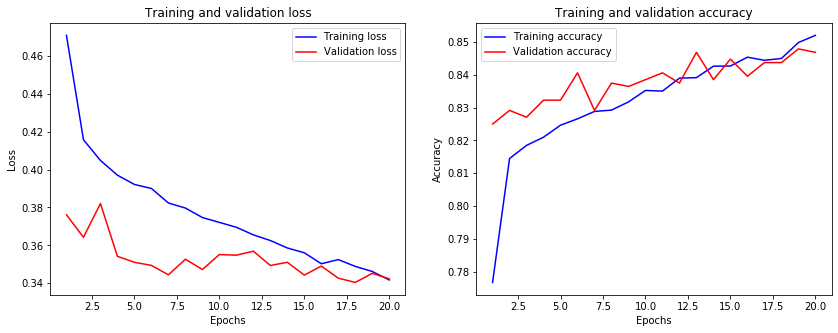

In [0]:
plot_metrics(results['v1'])

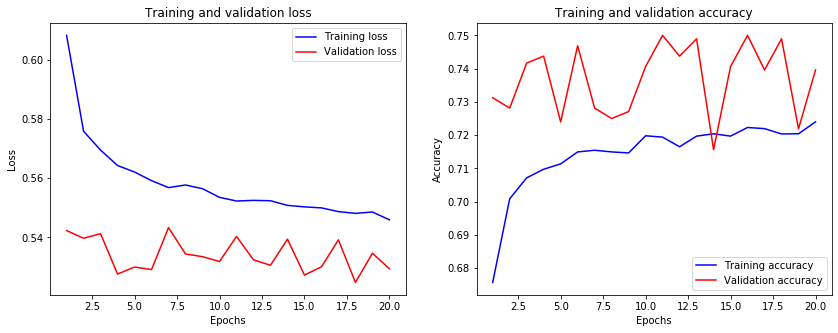

In [0]:
plot_metrics(results['v2'])

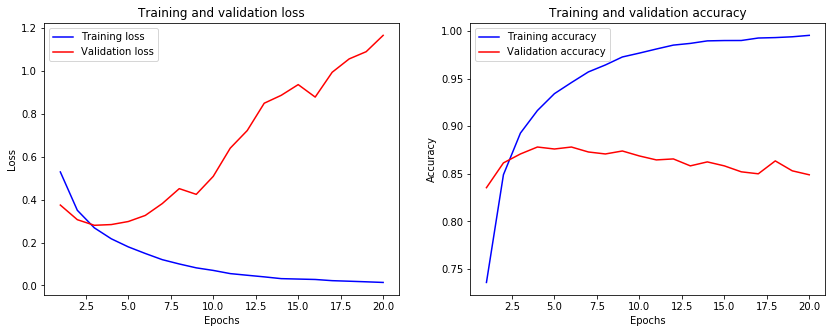

In [0]:
plot_metrics(results['v3'])